In [2]:
import importlib
import os
import pathlib
import sys
import matplotlib
%matplotlib inline
sys.path.append(f'{pathlib.Path(os.path.abspath("")).parents[0]}')

In [3]:
from scripts import read, cop, process, analyze, plot

# Import Data

### Ecobee

Imports the data through the "analyze" package. This assumes a processed "df_list" is located in "data/pickled_data". The default system is labeled gas, which refers to any non-heat pump (hp) system. Ecobee dict contains a dictionary of various dataframes used for later analysis.

To import data directly from csv files, run read.main(). This will pickle files in the "data_dir/df_lists" directory.

## data_dir

Should have the structure:
 - meta_data.csv
 - heat_loads
     - Contains alternative heat loads to compare to
 - df_lists
     - Contains pickled df_lists created by read.main()
 - weather
     - location_dirs: Contains directories of locations with:
         - wind_speed.csv
         - solar files downloaded from NSRDB for various locations within analyzed region


In [7]:
# To import data directly from csv files, run read.main()
location = 'NY'
data_dir = f'{pathlib.Path(os.path.abspath("")).parents[1]}/data'
reduce_size = True
season='winter'
hp_only = False
read.main(location, data_dir, reduce_size, season, hp_only)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Zach\\Documents\\Cornell_Stuff\\Research/data_files/meta_data.csv'

In [3]:
# Imports df_lists into a dict for easier processing
ecobee_dict = analyze.import_ecobee_data(location='NY', size='small', fuel_type='gas')
ecobee_dict_hp = analyze.import_ecobee_data(location='NY', size='small', fuel_type='hp')

### Other Loads

Imports other loads used as baseline comparisons. 

 - When2heat (https://github.com/oruhnau/when2heat)
 - Synpro (https://www.sciencedirect.com/science/article/abs/pii/S0378778815000845)
 - NREL (https://data.openei.org/submissions/153)

In [4]:
# Daily Average
when2heat_daily = analyze.import_other_heat_data('when2heat', location='DE', daily=True)   
synpro_daily = analyze.import_other_heat_data('synpro', daily=True)   
nrel_daily = analyze.import_other_heat_data('nrel', location='NYC', daily=True) 

# Yearly Data
when2heat = analyze.import_other_heat_data('when2heat', location='DE', daily=False)   
# synpro_daily = analyze.import_other_heat_data('synpro', daily=True)   #Synpro does not give yearly data
nrel = analyze.import_other_heat_data('nrel', location='NYC', daily=False) 

# Setpoint profiles

Plots the daily average setpoint profiles for the ecobee data

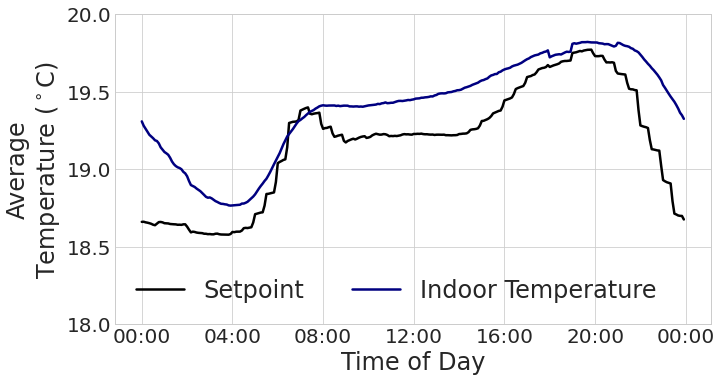

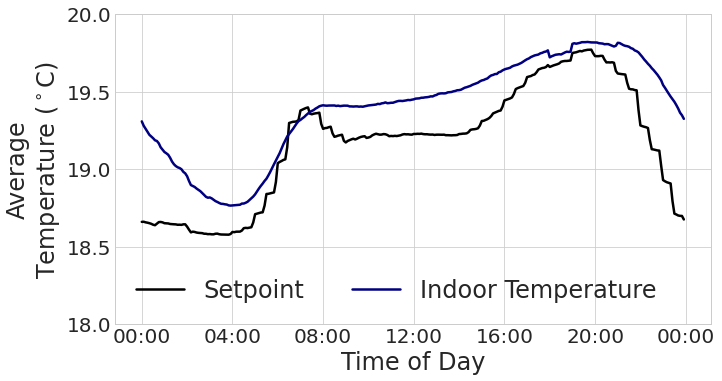

In [5]:
f, ax = plot.plot_setpoints(ecobee_dict['grouped_df'], day='weekday')
f, ax = plot.plot_setpoints(ecobee_dict['grouped_df'], day='weekend')

# Daily Profile

Plots the daily average heating demand profiles for a list of input data.

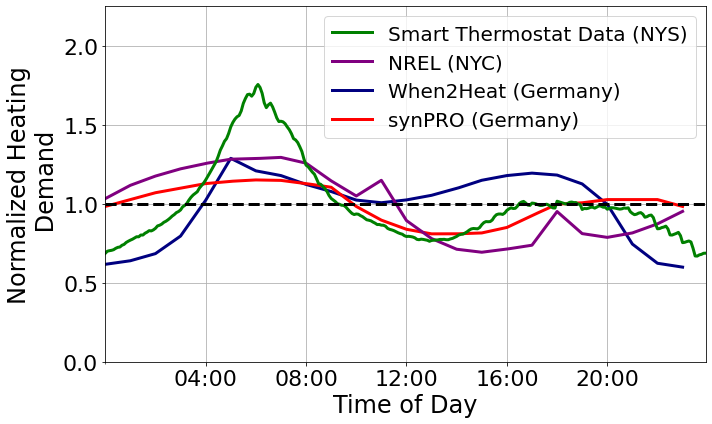

In [6]:
f, ax = plot.plot_daily_heating_demand([when2heat_daily,
                                       synpro_daily, 
                                       nrel_daily, 
                                       ecobee_dict['grouped_daily']['effectiveHeatNorm'],
#                                        ecobee_dict_hp['grouped_daily']['effectiveHeatNorm']
                                       ],
                                      label_list=['When2Heat (Germany)',
                                                 f'synPRO (Germany)', 
                                                  f'NREL (NYC)',
                                                  'Smart Thermostat Data (NYS)',
#                                                  'Smart Thermostat HP Data (NYS)'
                                                 ])

## Daily Peaks

Plots a histogram of the daily peak loads and their averages. `data_peaks` gives the contains the peak heating demand for each day in the corresponding dataset.

In [7]:
ecobee_peaks = analyze.get_daily_peaks(ecobee_dict['grouped_df']['effectiveHeatNorm'])
nrel_peaks = analyze.get_daily_peaks(nrel)
when2heat_peaks = analyze.get_daily_peaks(when2heat)

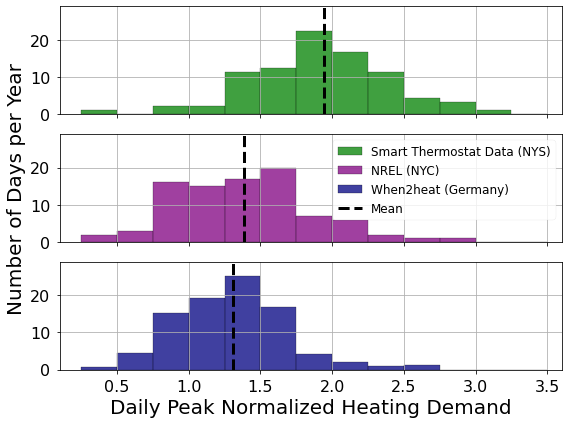

In [8]:
f, axs = plot.plot_daily_peaks([ecobee_peaks, nrel_peaks, when2heat_peaks],
                              label_list=['Smart Thermostat Data (NYS)', 'NREL (NYC)', 'When2heat (Germany)'])

## Renewable Correlation

Plots the correlation with renewable energy. "High Demand, Low Resource Periods" refers to times where wind is below the `wind_thresh`, solar is below the `solar_thresh`, and heating demand is above `demand_thresh`. Each dot represents a different time period corresponding to the `resample_freq`.

High Demand, Low Resource:  0
High Demand 324
Percent:  0.0


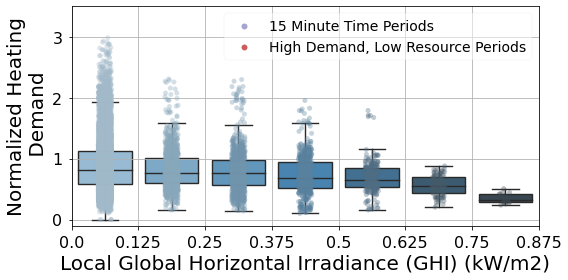

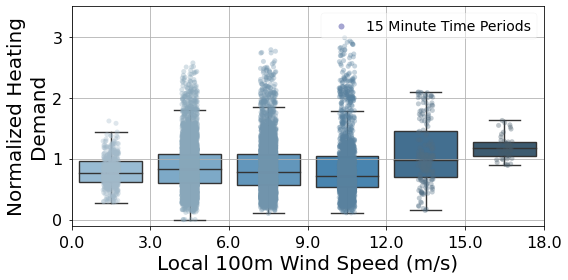

In [9]:
grouped_loc_df_resample, low_resource_high_demand = analyze.renewable_correlation(ecobee_dict['grouped_df_loc'], resample_freq='15T', 
                                        wind_thresh=3.5, solar_thresh=.05, demand_thresh=2)
f, axs = plot.plot_renewable_correlation(grouped_loc_df_resample, low_resource_high_demand)

High Demand, Low Resource:  0
High Demand 324
Percent:  0.0


(<Figure size 576x288 with 2 Axes>,
 <AxesSubplot:xlabel='Normalized Heating Demand', ylabel='Mean Local 100m\nWind Speed (m/s)'>)

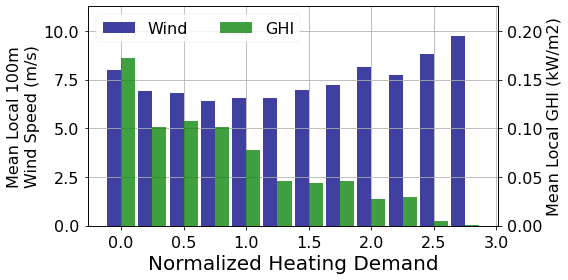

In [10]:
f, axs = plot.plot_renewable_time(*analyze.renewable_correlation(ecobee_dict['grouped_df_loc'], resample_freq='15T', 
                                        wind_thresh=3.5, solar_thresh=.05, demand_thresh=2))